In [1]:
import sys
import os
import numpy as np 
import matplotlib as mpl 
from config.plot_config_2 import *

sys.path.append(os.path.abspath('packages'))
from utilities import *

os.environ['PATH'] = os.environ['PATH'] + ':/usr/local/texlive/2023/bin/x86_64-linux' + ':/usr/bin/pdflatex'


plt.rc('text', usetex=False)
plt.rc('font', family='serif')


Loading plot config 2 <matplotlib.colors.ListedColormap object at 0x7ec35bf6da60>


### Loading data

In [2]:
t1_data = np.load('data/09_EGFR_MM_stoch.npy', allow_pickle=True)
t1_data = t1_data.item()

In [3]:
alpha_list = t1_data['alpha_list']
beta_list = t1_data['beta_list']
weights_list = t1_data['weights_list']
beta_err_list = t1_data['beta_error_list']
emp_var_list = t1_data['emp_var_list']
epsilon_list = t1_data['epsilon_list']
dt_list = t1_data['dt_list']
S_list = t1_data['S_list']

In [4]:
netw = make_par('egfr')
dynamics, S, f = get_dynamics()
netw['dynamics'] = dynamics
netw = refresh_netw_par(netw)
rates_par = get_rates_par()

In [5]:
true_weights, features = get_true_weights(netw['units_subnw'], **rates_par)
pred_weights = np.mean(weights_list, axis=2)[0, 0]

In [6]:
true_weights[8]@features

0.003*x_{GRb}*x_{RP} + 0.06*x_{RGS} - 0.01*x_{RG}*x_{SOS} - 0.05*x_{RG}

### Weight predictions

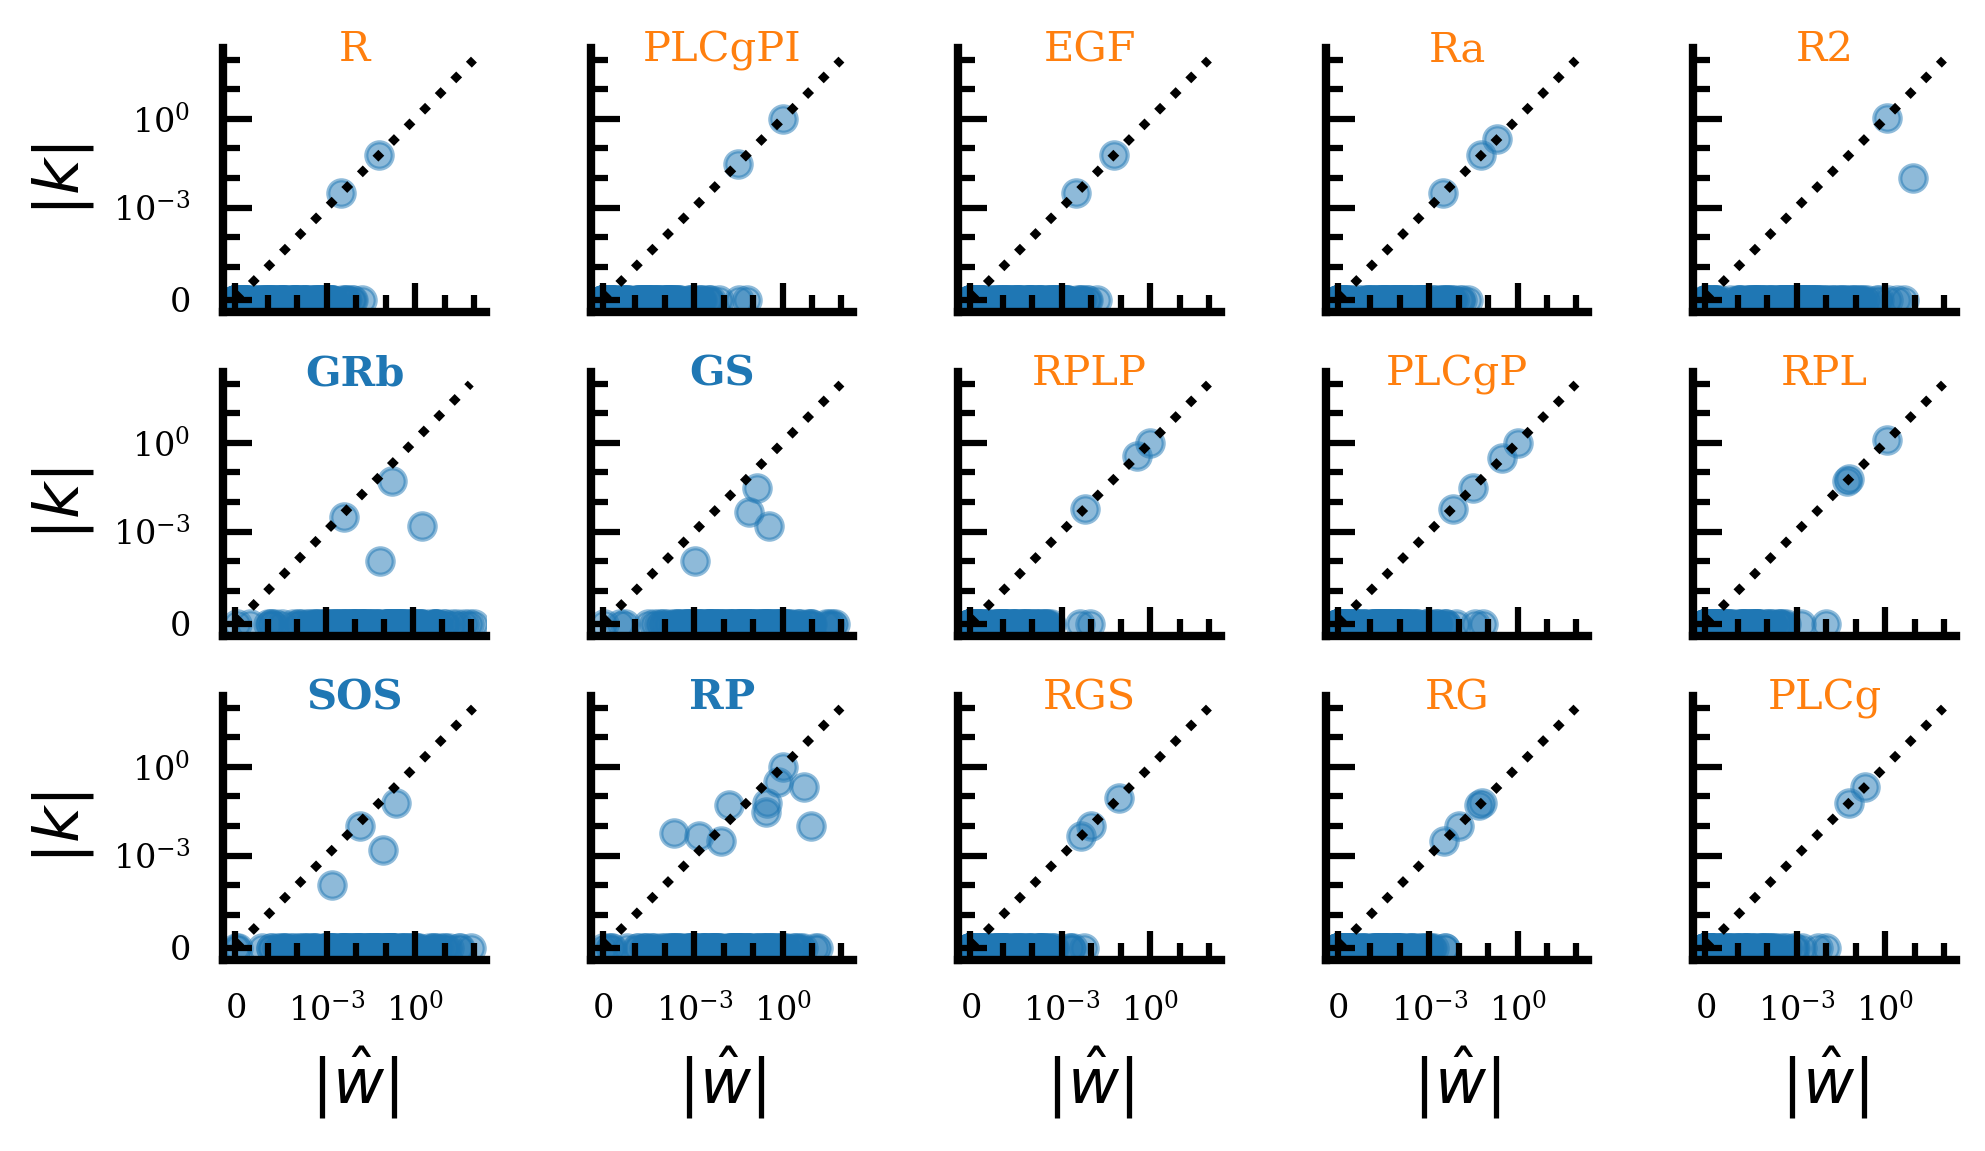

In [7]:
fig = plt.figure(figsize=(7, 4))

fs = 15

u_sub = {unit:idx for idx, unit in enumerate(netw['units_subnw'])}

u2 = ['SOS', 'RP', 'GRb', 'GS', 'PLCg', 'R', 'RPL', 'RPLP', 'PLCgP', 'RG', 'RGS', 'PLCgPI', 'EGF', 'Ra', 'R2',]
u3 = ['SOS', 'RP', 'RGS', 'RG', 'PLCg', 'GRb', 'GS', 'RPLP', 'PLCgP', 'RPL', 'R', 'PLCgPI', 'EGF', 'Ra', 'R2',]# 'ShGS', 'ShP', 'Shc', 'RShGS', 'RShP', 'RSh', 'RShG', 'ShG']

u1 = ['EGF', 'Ra', 'RGS', 'GS', 'GRb', 'PLCgPI', 'SOS', 'RP', 'R2',]

units = u3
linthresh = 1e-5

axes = []

dx, dy = .125, .22
sx, sy = .05, .05
h, w = .15, .13

for idx, unit in enumerate(units): 
    i_row = idx // 5
    i_col = idx % 5

    axes.append(fig.add_axes([w + (dx + sx) * i_col, h + (dy + sy)*i_row , dx, dy]))
    scale = mpl.scale.SymmetricalLogScale(axes[idx], linthresh=linthresh)
    axes[idx].set_xscale(scale)
    axes[idx].set_yscale(scale)
    axes[idx].xaxis.set_major_locator(mpl.ticker.FixedLocator([0, 1e-3, 1e0, 1e3]))
    axes[idx].yaxis.set_major_locator(mpl.ticker.FixedLocator([0, 1e-3, 1e0, 1e3]))


    axes[idx].xaxis.set_tick_params(which='major', size=7, width=1.5, direction='in', top=False)
    axes[idx].xaxis.set_tick_params(which='minor', size=4, width=1.5, direction='in' , top=False)
    axes[idx].yaxis.set_tick_params(which='major', size=7, width=1.5, direction='in', right=False)
    axes[idx].yaxis.set_tick_params(which='minor', size=4, width=1.5, direction='in' , right=False)

    if i_row != 0: 
        axes[idx].xaxis.set_ticklabels([])
    else: axes[idx].set_xlabel(r'$|\hat w|$', fontsize=fs)
    if i_col != 0: 
        axes[idx].yaxis.set_ticklabels([])
    else: axes[idx].set_ylabel(r'$|k|$', fontsize=fs)

for idx, unit in enumerate(units): 
    idx_u = u_sub[unit]
    ax = axes[idx]
    title =  f'{unit}'

    

    weight = 'bold' if unit in netw['units_boundary']  else 'normal'
    color = COLORS(0) if unit in netw['units_boundary']  else COLORS(1)
    ax.set_title(title, fontweight = weight, color=color,  pad=0, y=.95, fontsize=10)

    x_lin = np.linspace(0, 1e2, 2)
    ax.plot(x_lin, x_lin, color='k', lw=2, ls ='dotted')
    ax.scatter(np.abs(pred_weights[idx_u]), np.abs(true_weights[idx_u]), alpha=.5, s=40)


    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)





### Concentration trajectories 

#### Simulating Data 

In [8]:

epsilon = 1e-5 #epsilon_list[0]
stdv = .3
n_runs = 3

T = 10 
t_eval = np.linspace(0, T, 1000)

netw = make_par('egfr')
det_dyn, S, flux = get_dynamics()
netw['dynamics'] = det_dyn
netw = refresh_netw_par(netw)


stoch_dyn = get_stoch_term(epsilon, S, flux)
y_val = load_rubin14_MM_yvals(y_vals_file='packages/parameters/EGFR/yvals.txt')        
np.random.seed(0)
init_list = [np.abs(y_val * ( 1 +  np.random.normal(0, stdv, len(y_val)))) for i in range(n_runs)] 


In [9]:
from tqdm import tqdm  

x = None
der = None 
bar = tqdm(range(n_runs), total=n_runs)
for r in bar: 
    init = init_list[r]    
    sol_stoch = int_ito(det_dyn, stoch_dyn, init, t_eval=t_eval)
    x_stoch = sol_stoch[:, :]  # extract the concentrations of the observed units 

    if x is None: 
        x = x_stoch
        der = np.gradient(x_stoch, t_eval, axis=1)
    else: 
        der = np.append(der, np.gradient(x_stoch, t_eval, axis=1), axis=1)
        x = np.append(x, x_stoch, axis=1)            
    

x = x.T
der = der.T

100%|██████████| 3/3 [00:00<00:00,  4.17it/s]


/tmp/ipykernel_228242/3201999777.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(mpl.ticker.FixedFormatter([0, T, 0, T , 0,  T]))
/tmp/ipykernel_228242/3201999777.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(mpl.ticker.FixedFormatter([0, T, 0, T , 0,  T]))
/tmp/ipykernel_228242/3201999777.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(mpl.ticker.FixedFormatter([0, T, 0, T , 0,  T]))
/tmp/ipykernel_228242/3201999777.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(mpl.ticker.FixedFormatter([0, T, 0, T , 0,  T]))
/tmp/ipykernel_228242/3201999777.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(mpl.ticker.FixedFormatter([0, T, 0, T , 0,  T]))
/tmp/ipykernel_228242/320

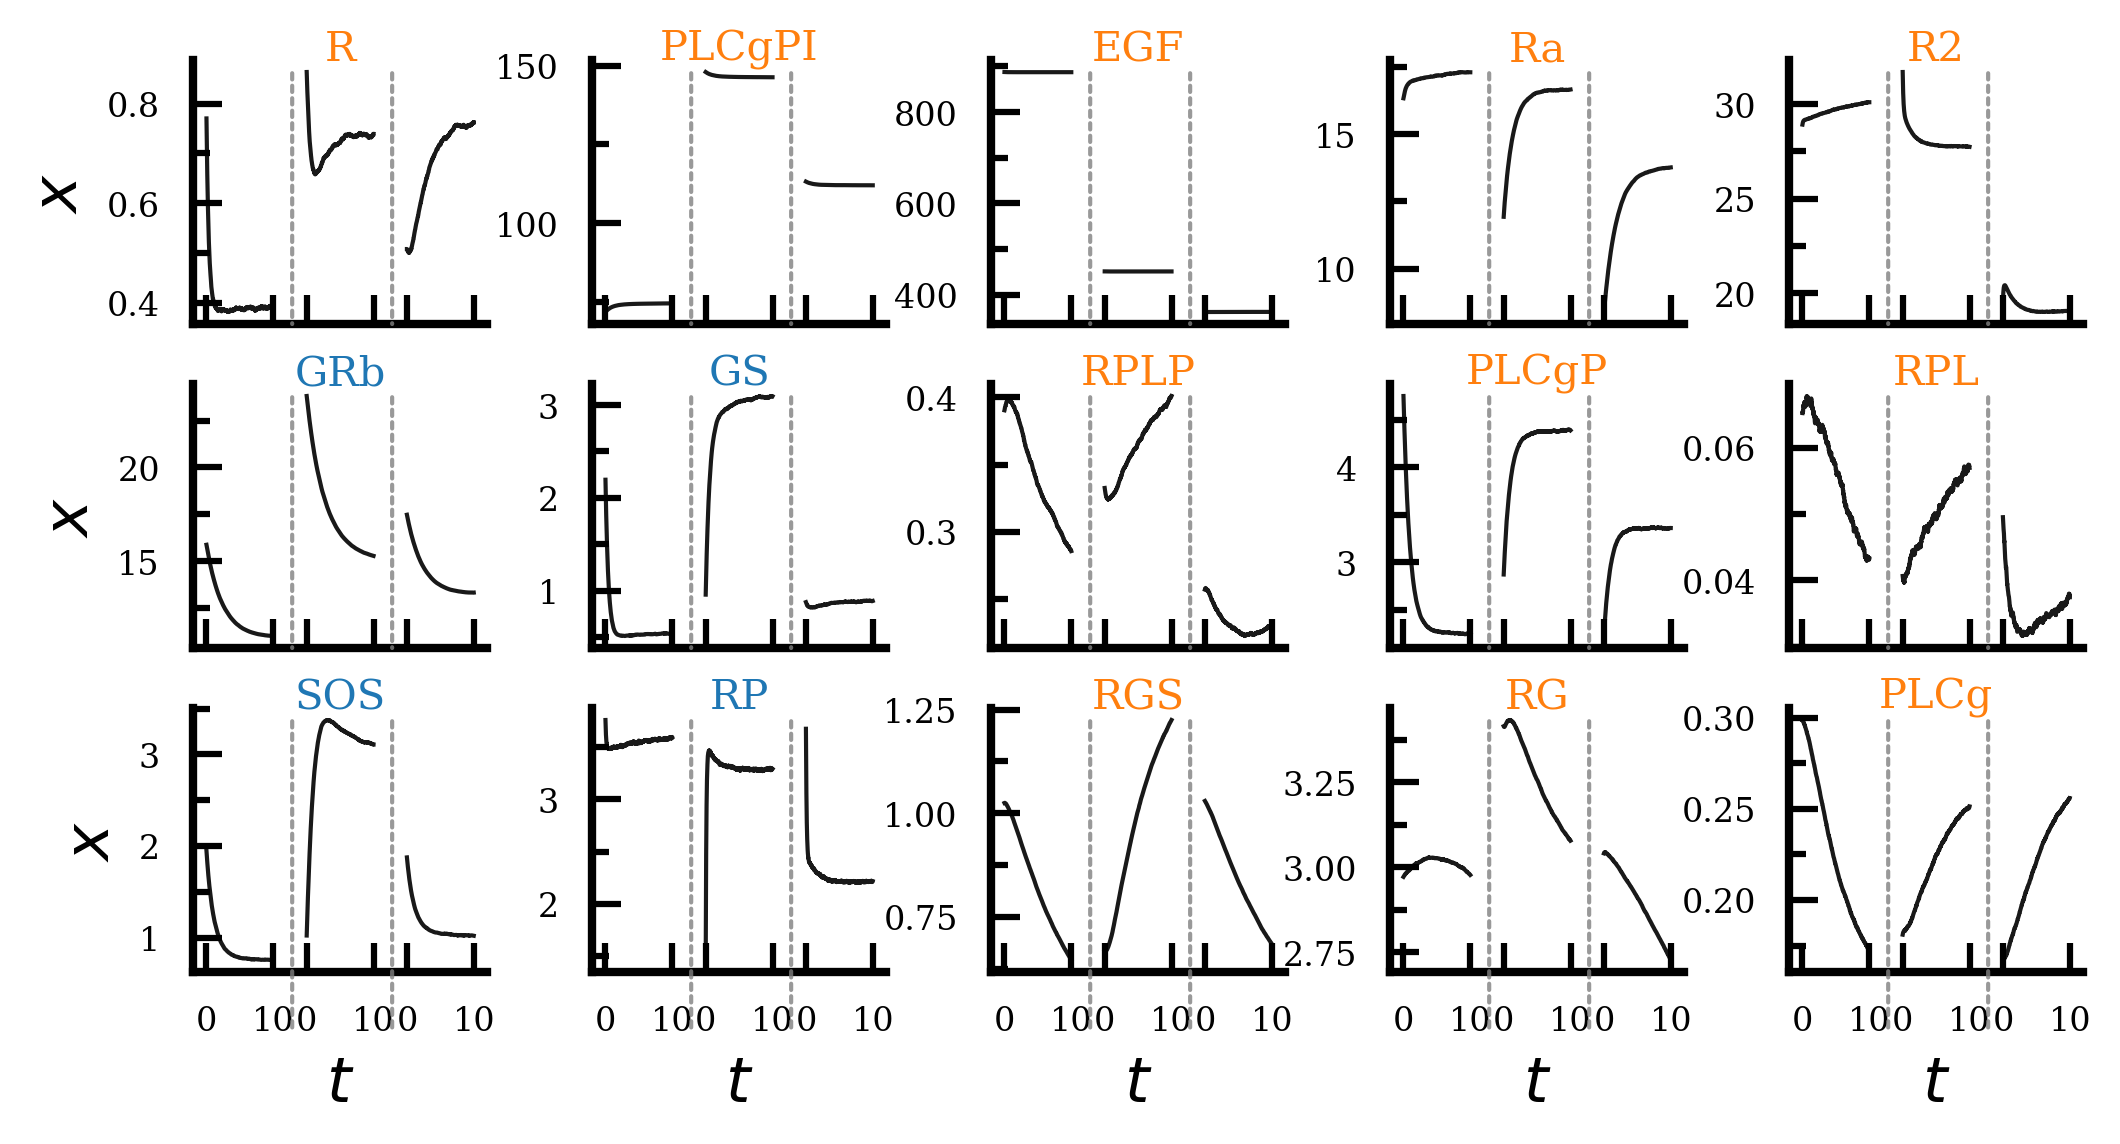

In [10]:
fig = plt.figure(figsize=(7, 4))

u_sub = {unit:idx for idx, unit in enumerate(netw['units'])}

units = ['SOS', 'RP', 'RGS', 'RG', 'PLCg', 'GRb', 'GS', 'RPLP', 'PLCgP', 'RPL', 'R', 'PLCgPI', 'EGF', 'Ra', 'R2']#, 'ShGS', 'ShP', 'Shc', 'RShGS', 'RShP', 'RSh', 'RShG', 'ShG']

linthresh = 1e-5

axes = []
fs = 15
dx, dy = .14, .22
sx, sy = .05, .05
h, w = .15, .09


for idx, unit in enumerate(units): 
    i_row = idx // 5
    i_col = idx % 5

    axes.append(fig.add_axes([w + (dx + sx) * i_col, h + (dy + sy)*i_row , dx, dy]))


pert_dx = T/2

for idx, unit in enumerate(units): 

    idx_u = u_sub[unit]
    ax = axes[idx]
    title =  f'{unit}'
    color = COLORS(0) if unit in netw['units_boundary'] else (COLORS(1) if unit in netw['units_inner'] else 'grey')
    ax.set_title(title, fontweight = weight, color=color,  pad=0, y = 1, fontsize=10)

    for pert in range(3): 
        N_pert = len(t_eval)
        y = x[N_pert*pert:N_pert*(pert+1),idx_u]
        x_lin = np.linspace(pert*pert_dx + pert*T, pert*pert_dx + T*(pert + 1), y.shape[0])
        # Edit the major and minor ticks of the x and y 
        
        ax.plot(x_lin, y, color='k', alpha=.9, lw=1)#, label=label_pred, )
                                 

    i_row = idx // 5
    i_col = idx % 5


    T1, T2 = .337, .677
    y1, y2 = 0, .95
    ax.xaxis.set_major_formatter(mpl.ticker.FixedFormatter([0, T, 0, T , 0,  T]))

    if i_row != 0: 
        axes[idx].xaxis.set_ticklabels([])
        
    else: 
        y1, y2 = -.21, .95
        axes[idx].set_xlabel(r'$t$', fontsize=fs)
    if i_col == 0:      
        axes[idx].set_ylabel(r'$x$', fontsize=fs)#transform =axes[idx].transData)
    
    ax.xaxis.set_major_locator(mpl.ticker.FixedLocator([0, T, T+pert_dx, 2*T + pert_dx, 2*T + 2*pert_dx, 3*T + 2*pert_dx]))
    ax.xaxis.set_minor_locator(mpl.ticker.NullLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(n=2))
    
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

    
    ax.xaxis.set_tick_params(which='major', size=7, width=1.5, direction='in', top=False)
    ax.xaxis.set_tick_params(which='minor', size=4, width=1.5, direction='in' , top=False)
    ax.yaxis.set_tick_params(which='major', size=7, width=1.5, direction='in', right=False)
    ax.yaxis.set_tick_params(which='minor', size=4, width=1.5, direction='in' , right=False)


    min_ax = np.min(x[:N_pert*3,idx_u])
    max_ax = np.max(x[:N_pert*3,idx_u])    


    ls = (0, (1.5, 1.5))
    ax.annotate('', (T1, y1), (T1, y2), xycoords='axes fraction',#, transform=ax.transAxes,
             arrowprops=dict( linewidth=2,
                            #fc="0.6", ec="none",
                            arrowstyle= '-', linestyle= ls,color='grey', alpha=.8, lw=1,
                            #patchB=el,
                            shrinkA = 0, shrinkB =0,
                            connectionstyle="arc3,rad=0"))


    
    ax.annotate('', (T2,  y1 ), (T2, y2), xycoords='axes fraction',#, transform=ax.transAxes,
                arrowprops=dict( linewidth=2,
                            #fc="0.6", ec="none",
                            arrowstyle= '-', linestyle= ls,color='grey', alpha=.8, lw=1,
                            #patchB=el,
                            shrinkA = 0, shrinkB =0,
                            connectionstyle="arc3,rad=0"))




### Time derivatives 

In [11]:
def var_pred(phi, beta, Sn): 
    return np.array([[1/beta[i] + phi[t]@Sn[i]@phi[t].T for t in range(phi.shape[0])] for i in range(beta.shape[0])])

In [12]:
idx_t = 3
idx_eps = 4
#dt = dt_list[0]
weigh = np.mean(weights_list, axis=2)[idx_eps, idx_t]
beta_mean =  np.mean(beta_list, axis=2)[idx_eps, idx_t]
Sn = np.mean(S_list, axis=2)[idx_eps, idx_t]

phi = design_matrix_2(x[:, netw['idx_subnw']])
var = var_pred(phi, beta=beta_mean, Sn=Sn)


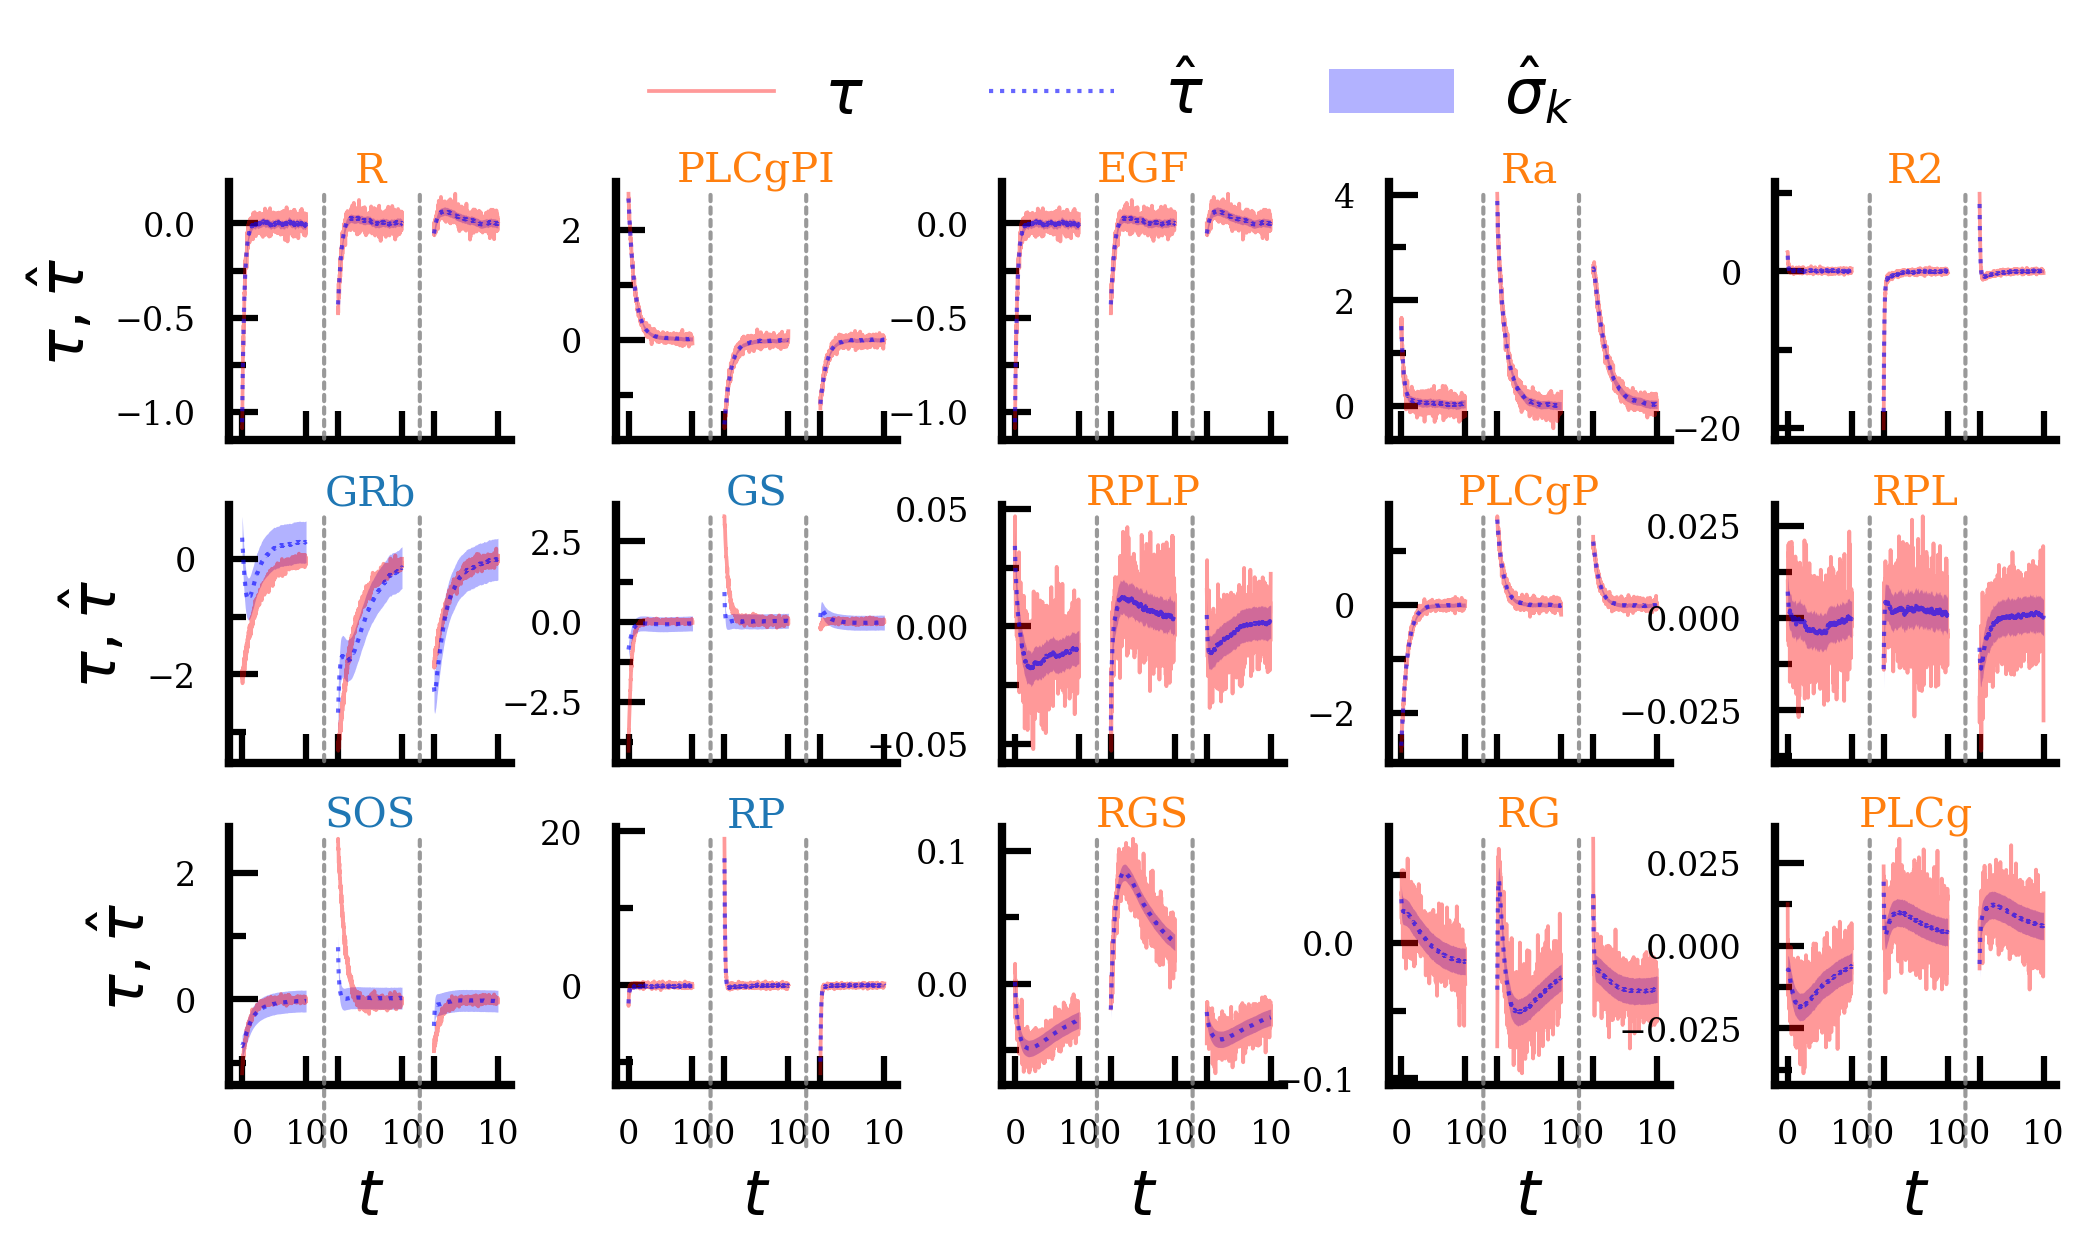

In [13]:
fig = plt.figure(figsize=(7, 4.3))

u_sub = {unit:idx for idx, unit in enumerate(netw['units_subnw'])}

units = ['SOS', 'RP', 'RGS', 'RG', 'PLCg', 'GRb', 'GS', 'RPLP', 'PLCgP', 'RPL', 'R', 'PLCgPI', 'EGF', 'Ra', 'R2',]
#units = ['EGF', 'Ra', 'RGS', 'RG', 'PLCg', 'R', 'RPL', 'RPLP', 'PLCgP', 'GS', 'GRb', 'PLCgPI', 'SOS', 'RP', 'R2',]

linthresh = 1e-5

axes = []
#dx, dy = .229, .22*3/5
#sx, sy = .08, .087*3/5
#h, w = .07, .138

dx, dy = .134, .2
sx, sy = .05, .05
h, w = .145, .11

for idx, unit in enumerate(units): 
    i_row = idx // 5
    i_col = idx % 5

    axes.append(fig.add_axes([w + (dx + sx) * i_col, h + (dy + sy)*i_row , dx, dy]))




pert_dx = T/2



for idx, unit in enumerate(units): 

    idx_u = u_sub[unit]
    ax = axes[idx]
    
    ax.xaxis.set_tick_params(which='major', size=7, width=1.5, direction='in', top=False)
    ax.xaxis.set_tick_params(which='minor', size=4, width=1.5, direction='in' , top=False)
    ax.yaxis.set_tick_params(which='major', size=7, width=1.5, direction='in', right=False)
    ax.yaxis.set_tick_params(which='minor', size=4, width=1.5, direction='in' , right=False)


    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)



    title =  f'{unit}'
    color = COLORS(0) if unit in netw['units_boundary'] else (COLORS(1) if unit in netw['units_inner'] else 'grey')
    ax.set_title(title, fontweight = weight, color=color,  pad=0, y = 1, fontsize=10)
        


    for pert in range(3): 
        N_pert = len(t_eval)
        y = np.gradient(x[N_pert*pert:N_pert*(pert+1), netw['idx_subnw'][idx_u]], t_eval, axis=0)
        #der[N_pert*pert:N_pert*(pert+1),netw['idx_subnw'][idx_u]]
        
        y_pred = (weigh[idx_u]@phi.T)    
        x_lin = np.linspace(pert*pert_dx + pert*T, pert*pert_dx + T*(pert + 1), y.shape[0])            
        
        # variance 
        if pert ==0: 
            label1 = s_target
            label2 = s_sigma
            label3 = s_prediction
        else: 
            label1 = ''
            label2 = ''
            label3 = ''
        ax.plot(x_lin, y, color='red', alpha=.4, lw=.9, label=label1)#, label=label_pred, )
        ax.plot(x_lin, y_pred[N_pert*pert:N_pert*(pert+1)],  color='blue', alpha=.6, lw=1, ls='dotted', label=label3)#, label=label_pred, )
        ax.fill_between(x_lin, y_pred[N_pert*pert:N_pert*(pert+1)] + np.sqrt(var[idx_u, N_pert*pert:N_pert*(pert+1)]), y_pred[N_pert*pert:N_pert*(pert+1)] - np.sqrt(var[idx_u, N_pert*pert:N_pert*(pert+1)]), color='blue', alpha=.3, lw=0, label=label2)       
                                     
      
      
    ax.xaxis.set_major_locator(mpl.ticker.FixedLocator([0, T, T+pert_dx, 2*T + pert_dx, 2*T + 2*pert_dx, 3*T + 2*pert_dx]))
    ax.xaxis.set_minor_locator(mpl.ticker.NullLocator())
    
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(n=2))
    ax.xaxis.set_major_formatter(mpl.ticker.FixedFormatter([0, T, 0, T , 0,  T]))

    i_row = idx // 5
    i_col = idx % 5

    T1, T2 = .337, .677
    y1, y2 = 0, .95

    if i_row != 0: 
        
        axes[idx].xaxis.set_ticklabels([])
        
    else: 
        axes[idx].set_xlabel(r'$t$', fontsize=fs)
        y1, y2 = -.26, .95
    if i_col == 0:      
        axes[idx].set_ylabel(r'$\tau, \hat \tau$',fontsize=fs)#transform =axes[idx].transData)
        
    min_ax = np.min(x[:N_pert*3,idx_u])
    max_ax = np.max(x[:N_pert*3,idx_u])    


    ls = (0, (1.5, 1.5))
    ax.annotate('', (T1, y1), (T1, y2), xycoords='axes fraction',#, transform=ax.transAxes,
             arrowprops=dict( linewidth=2,
                            #fc="0.6", ec="none",
                            arrowstyle= '-', linestyle= ls,color='grey', alpha=.8, lw=1,
                            #patchB=el,
                            shrinkA = 0, shrinkB =0,
                            connectionstyle="arc3,rad=0"))


    
    ax.annotate('', (T2,  y1 ), (T2, y2), xycoords='axes fraction',#, transform=ax.transAxes,
                arrowprops=dict( linewidth=2,
                            #fc="0.6", ec="none",
                            arrowstyle= '-', linestyle= ls,color='grey', alpha=.8, lw=1,
                            #patchB=el,
                            shrinkA = 0, shrinkB =0,
                            connectionstyle="arc3,rad=0"))


axes[-1].legend(bbox_to_anchor=(-4.2, 1), loc=3, bbox_transform=axes[-1].transAxes, ncols=3, fontsize=fs)




In [14]:
def auc_roc_2(idx_boundary_rel,  beta, beta_error,num_threshold, method='total',plot=False, return_variance=False):
    
    """
    Calculates the Area under the curve for the ROC curve for a multiple data samples of the experiment with the given threshold and optionally plots them.
    
    Inputs:
    -beta         : beta values for repeated runs for all the subnetwork species as an np.array
    -beta_error   : corressponding standard deviation for the betas in the same form
    -num_threshold: the number of threshold values to be used, this determines the resolution of the ROC curve
    -num_bdry     : the number of boundary species in the network. We keep to the convention that the boundary speices are always first in any vector such as beta. = 1 by default
    -method       : 'total' = draw the ROC curve over different runs of the data first and then calculate the AUC 
                    'single'= draw the ROC for each run and calculate the AUC and then take the average
    -plot         : plot the ROC or not
    
    Output:
    - auc: the area under the curve
    
    """
    num_boundary = len(idx_boundary_rel)    
    Num_reps    = len(beta)
    tp,fp,fn,tn = np.zeros([Num_reps,num_threshold]),np.zeros([Num_reps,num_threshold]),np.zeros([Num_reps,num_threshold]),np.zeros([Num_reps,num_threshold])
    auc         = np.zeros(Num_reps)
    num_int     = len(beta[0]) - num_boundary #Number of internal species
    num_subnw = len(beta[0])

    
    # threshold   = np.geomspace(np.min(beta - 2*beta_error) ,np.max(beta+2*beta_error),num_threshold)
    
    idx_inner_rel = np.array([idx for idx in range(num_subnw) if idx not in idx_boundary_rel])
    for i in range(Num_reps):
        # threshold   = np.linspace(np.min(beta[i] - 2*beta_error[i]) ,np.max(beta[i]+2*beta_error[i]),num_threshold)
        t_min = np.min(beta[i] - 3*beta_error[i])
        if t_min <= 0: 
            threshold_1 = np.linspace(t_min, np.min(beta[i]), int(np.floor(num_threshold/5)))
            threshold_2 = np.geomspace(np.min(beta[i]), \
                np.max(beta[i]+3*beta_error[i]), int(np.ceil(4*num_threshold/5)))  
            threshold = np.array([*threshold_1, *threshold_2])
        else :
            threshold   = np.geomspace(t_min, \
                np.max(beta[i]+3*beta_error[i]),num_threshold)    # corresponding to 3 sigma interval

        for j in range(len(threshold)):
            t = 0.5*(1 + sc.special.erf((threshold[j] - beta[i,:])/(np.sqrt(2)*beta_error[i,:]))) 
            tp[i,j] += np.sum(t[idx_boundary_rel])
            fn[i,j] += num_boundary-np.sum(t[idx_boundary_rel])
            fp[i,j] += np.sum(t[idx_inner_rel])
            tn[i,j] += num_int - np.sum(t[idx_inner_rel]) 

    if method == 'total':
        auc = np.trapz(y=np.sum(tp,0)/(np.sum(tp,0)+np.sum(fn,0)),x=np.sum(fp,0)/(np.sum(fp,0)+np.sum(tn,0)))
        if plot:
            fig = plt.figure()
            plt.scatter(np.sum(fp,0)/(np.sum(fp,0)+np.sum(tn,0)),np.sum(tp,0)/(np.sum(tp,0)+np.sum(fn,0)),marker='.')
            plt.xlabel('False Positive fraction')
            plt.ylabel('True Positive fraction')
            plt.plot(np.sum(fp,0)/(np.sum(fp,0)+np.sum(tn,0)),np.sum(fp,0)/(np.sum(fp,0)+np.sum(tn,0)),'r--')
            plt.grid()    
            plt.title(f'individual thresholds - auc : {auc:.2f}')
            plt.show()
        return auc

    elif method == 'single':

        for i in range(Num_reps):
            auc[i] = np.trapz(y=tp[i]/(tp[i]+fn[i]),x=fp[i]/(fp[i]+tn[i]))

        auc_tot = np.trapz(y=np.sum(tp,0)/(np.sum(tp,0)+np.sum(fn,0)),x=np.sum(fp,0)/(np.sum(fp,0)+np.sum(tn,0)))
        auc_single, auc_var = np.mean(auc), np.var(auc)
        
        if plot:
            fig = plt.figure()
            plt.scatter(np.mean(fp/(fp+tn),0),np.mean(tp/(tp+fn),0),marker='.')
            plt.xlabel('False Positive fraction')
            plt.ylabel('True Positive fraction')
            plt.plot(np.mean(fp/(fp+tn),0),np.mean(fp/(fp+tn),0),'r--')
            plt.grid()
            
            plt.show()
        return (auc_tot, auc_single, auc_var)

## Comparing $\beta_\epsilon$ values 

### Definition of $\beta_\epsilon$ and using this quantity to identify boundary species 

In [15]:
beta_dev = np.abs(emp_var_list/(1/beta_list - emp_var_list))
beta_dev_err =  np.abs(emp_var_list/(1/beta_list - emp_var_list)**2 * 1/beta_list**2) * beta_err_list

beta_dev_mean = np.mean(beta_dev, axis=2)

#beta_dev = np.mean(beta_dev, axis=2)
#beta_dev_err = np.mean(beta_dev_err, axis=2)


### Visualizing $\beta$ values 

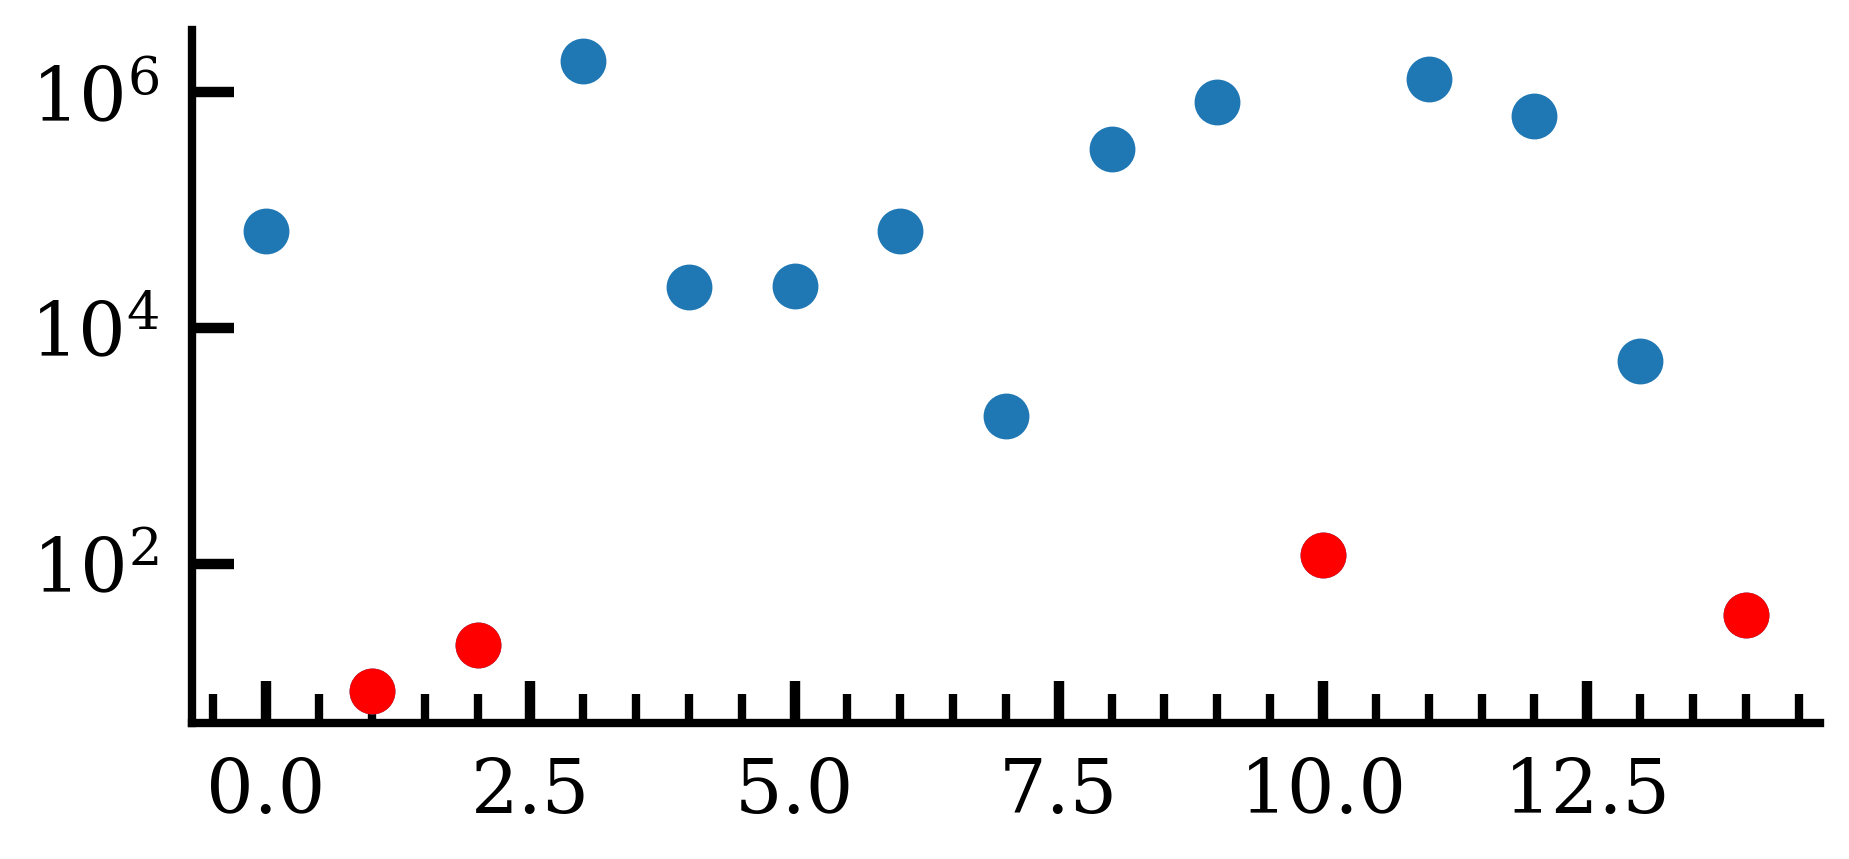

In [16]:
idx_dt = 0
idx_eps = 1
b = np.mean(beta_list[idx_eps, idx_dt], axis=0)
err = np.mean(beta_err_list[idx_eps, idx_dt], axis=0)


plt.errorbar(np.arange(len(netw['idx_subnw'])), b, yerr=err, fmt='o', label='Data', capsize=5)
#plt.scatter(, , color='r')
plt.errorbar(netw['idx_boundary_rel'], b[netw['idx_boundary_rel']], yerr=err[netw['idx_boundary_rel']], fmt='o', label='Data', capsize=5, color='red')
plt.yscale('log')

### Visualizing $\beta_\epsilon$ values

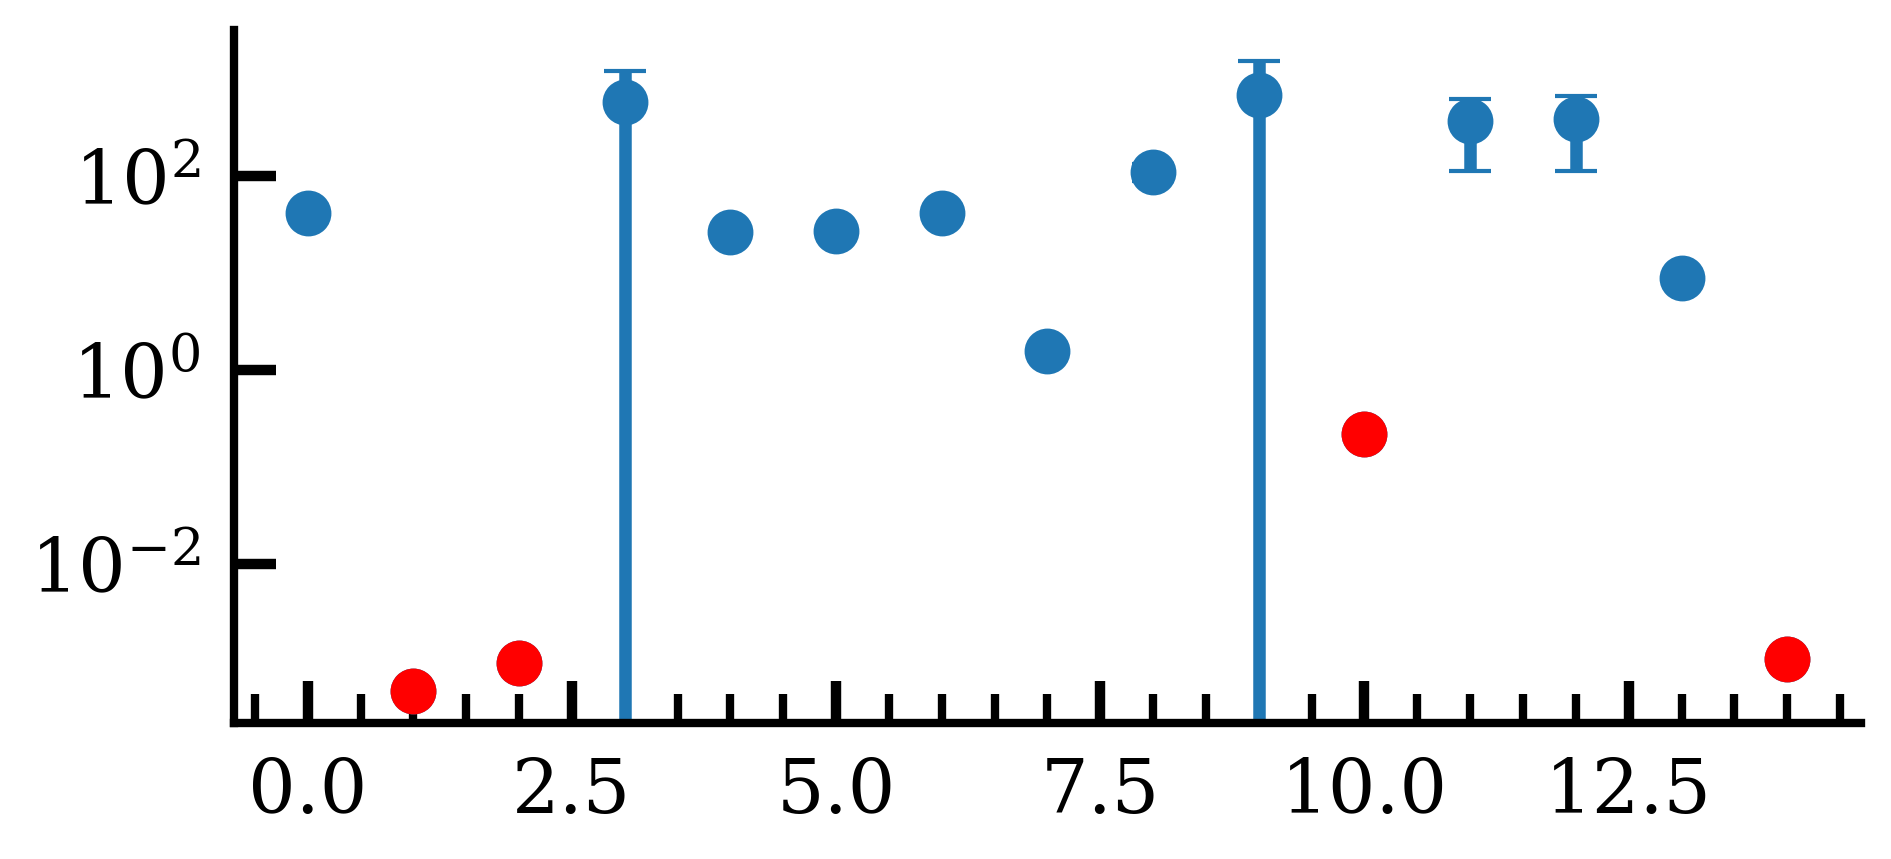

In [17]:
idx_dt = 0
idx_eps = 1
b = np.mean(beta_dev[idx_eps, idx_dt], axis=0)
err = np.mean(beta_dev_err[idx_eps, idx_dt], axis=0)


plt.errorbar(np.arange(len(netw['idx_subnw'])), b, yerr=err, fmt='o', label='Data', capsize=5)
#plt.scatter(, , color='r')
plt.errorbar(netw['idx_boundary_rel'], b[netw['idx_boundary_rel']], yerr=err[netw['idx_boundary_rel']], fmt='o', label='Data', capsize=5, color='red')
plt.yscale('log')

#### Calculating AUC values 

In [18]:

auc_sin = np.zeros((len(epsilon_list), len(dt_list) ))

for idx_dt, it in enumerate(dt_list): 
    for idx_eps, it2 in enumerate(epsilon_list): 
        auc_sin[idx_eps, idx_dt] = auc_roc_2(netw['idx_boundary_rel'], beta_list[ idx_eps, idx_dt], method='total',  beta_error=beta_err_list[idx_eps, idx_dt], num_threshold=1000)

#### AUC values for $\beta_\epsilon$

In [19]:
auc_dev =  np.zeros((len(epsilon_list), len(dt_list) ))
 
for idx_dt, _ in enumerate(dt_list): 
    for idx_eps, _ in enumerate(epsilon_list):
        auc_dev[idx_eps, idx_dt] = auc_roc_2(netw['idx_boundary_rel'], beta_dev[idx_eps, idx_dt], beta_error=beta_dev_err[idx_eps, idx_dt], num_threshold=1000, method='total', plot=False)
        

In [20]:
# Data Definition




idx_dt1 =2
idx_dt2 = 3


idx_dt_list = [idx_dt1, idx_dt2]

idx_sub_rel = {unit:idx for idx, unit in enumerate(netw['idx_subnw'])}
idx_sub_rel2 = {unit:idx for idx, unit in enumerate(netw['units_subnw'])}

grad_var_mean = np.mean(emp_var_list, axis=2)
beta_list_mean = np.mean(beta_list, axis=2)


## Plotting comparison to $\beta$

<>:58: SyntaxWarning: invalid escape sequence '\,'
<>:59: SyntaxWarning: invalid escape sequence '\,'
<>:113: SyntaxWarning: invalid escape sequence '\,'
<>:115: SyntaxWarning: invalid escape sequence '\,'
<>:151: SyntaxWarning: invalid escape sequence '\e'
<>:58: SyntaxWarning: invalid escape sequence '\,'
<>:59: SyntaxWarning: invalid escape sequence '\,'
<>:113: SyntaxWarning: invalid escape sequence '\,'
<>:115: SyntaxWarning: invalid escape sequence '\,'
<>:151: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_228242/3236201977.py:58: SyntaxWarning: invalid escape sequence '\,'
  ax.plot(epsilon_list, 1/beta_list_mean[:, idx_dt1, idx_l],alpha=alpha_m, marker=markers[0],label=s_dt + f':{dt_list[idx_dt1]:.0e}'+ '\,s', color=COLORS(0))
/tmp/ipykernel_228242/3236201977.py:59: SyntaxWarning: invalid escape sequence '\,'
  ax.plot(epsilon_list, 1/beta_list_mean[:, idx_dt2, idx_l],alpha=alpha_m, marker=markers[1],label=s_dt + f':{dt_list[idx_dt2]:.0e}' + '\,s', color=COLORS(1))

Text(-0.38, 0.85, '${(c)}$')

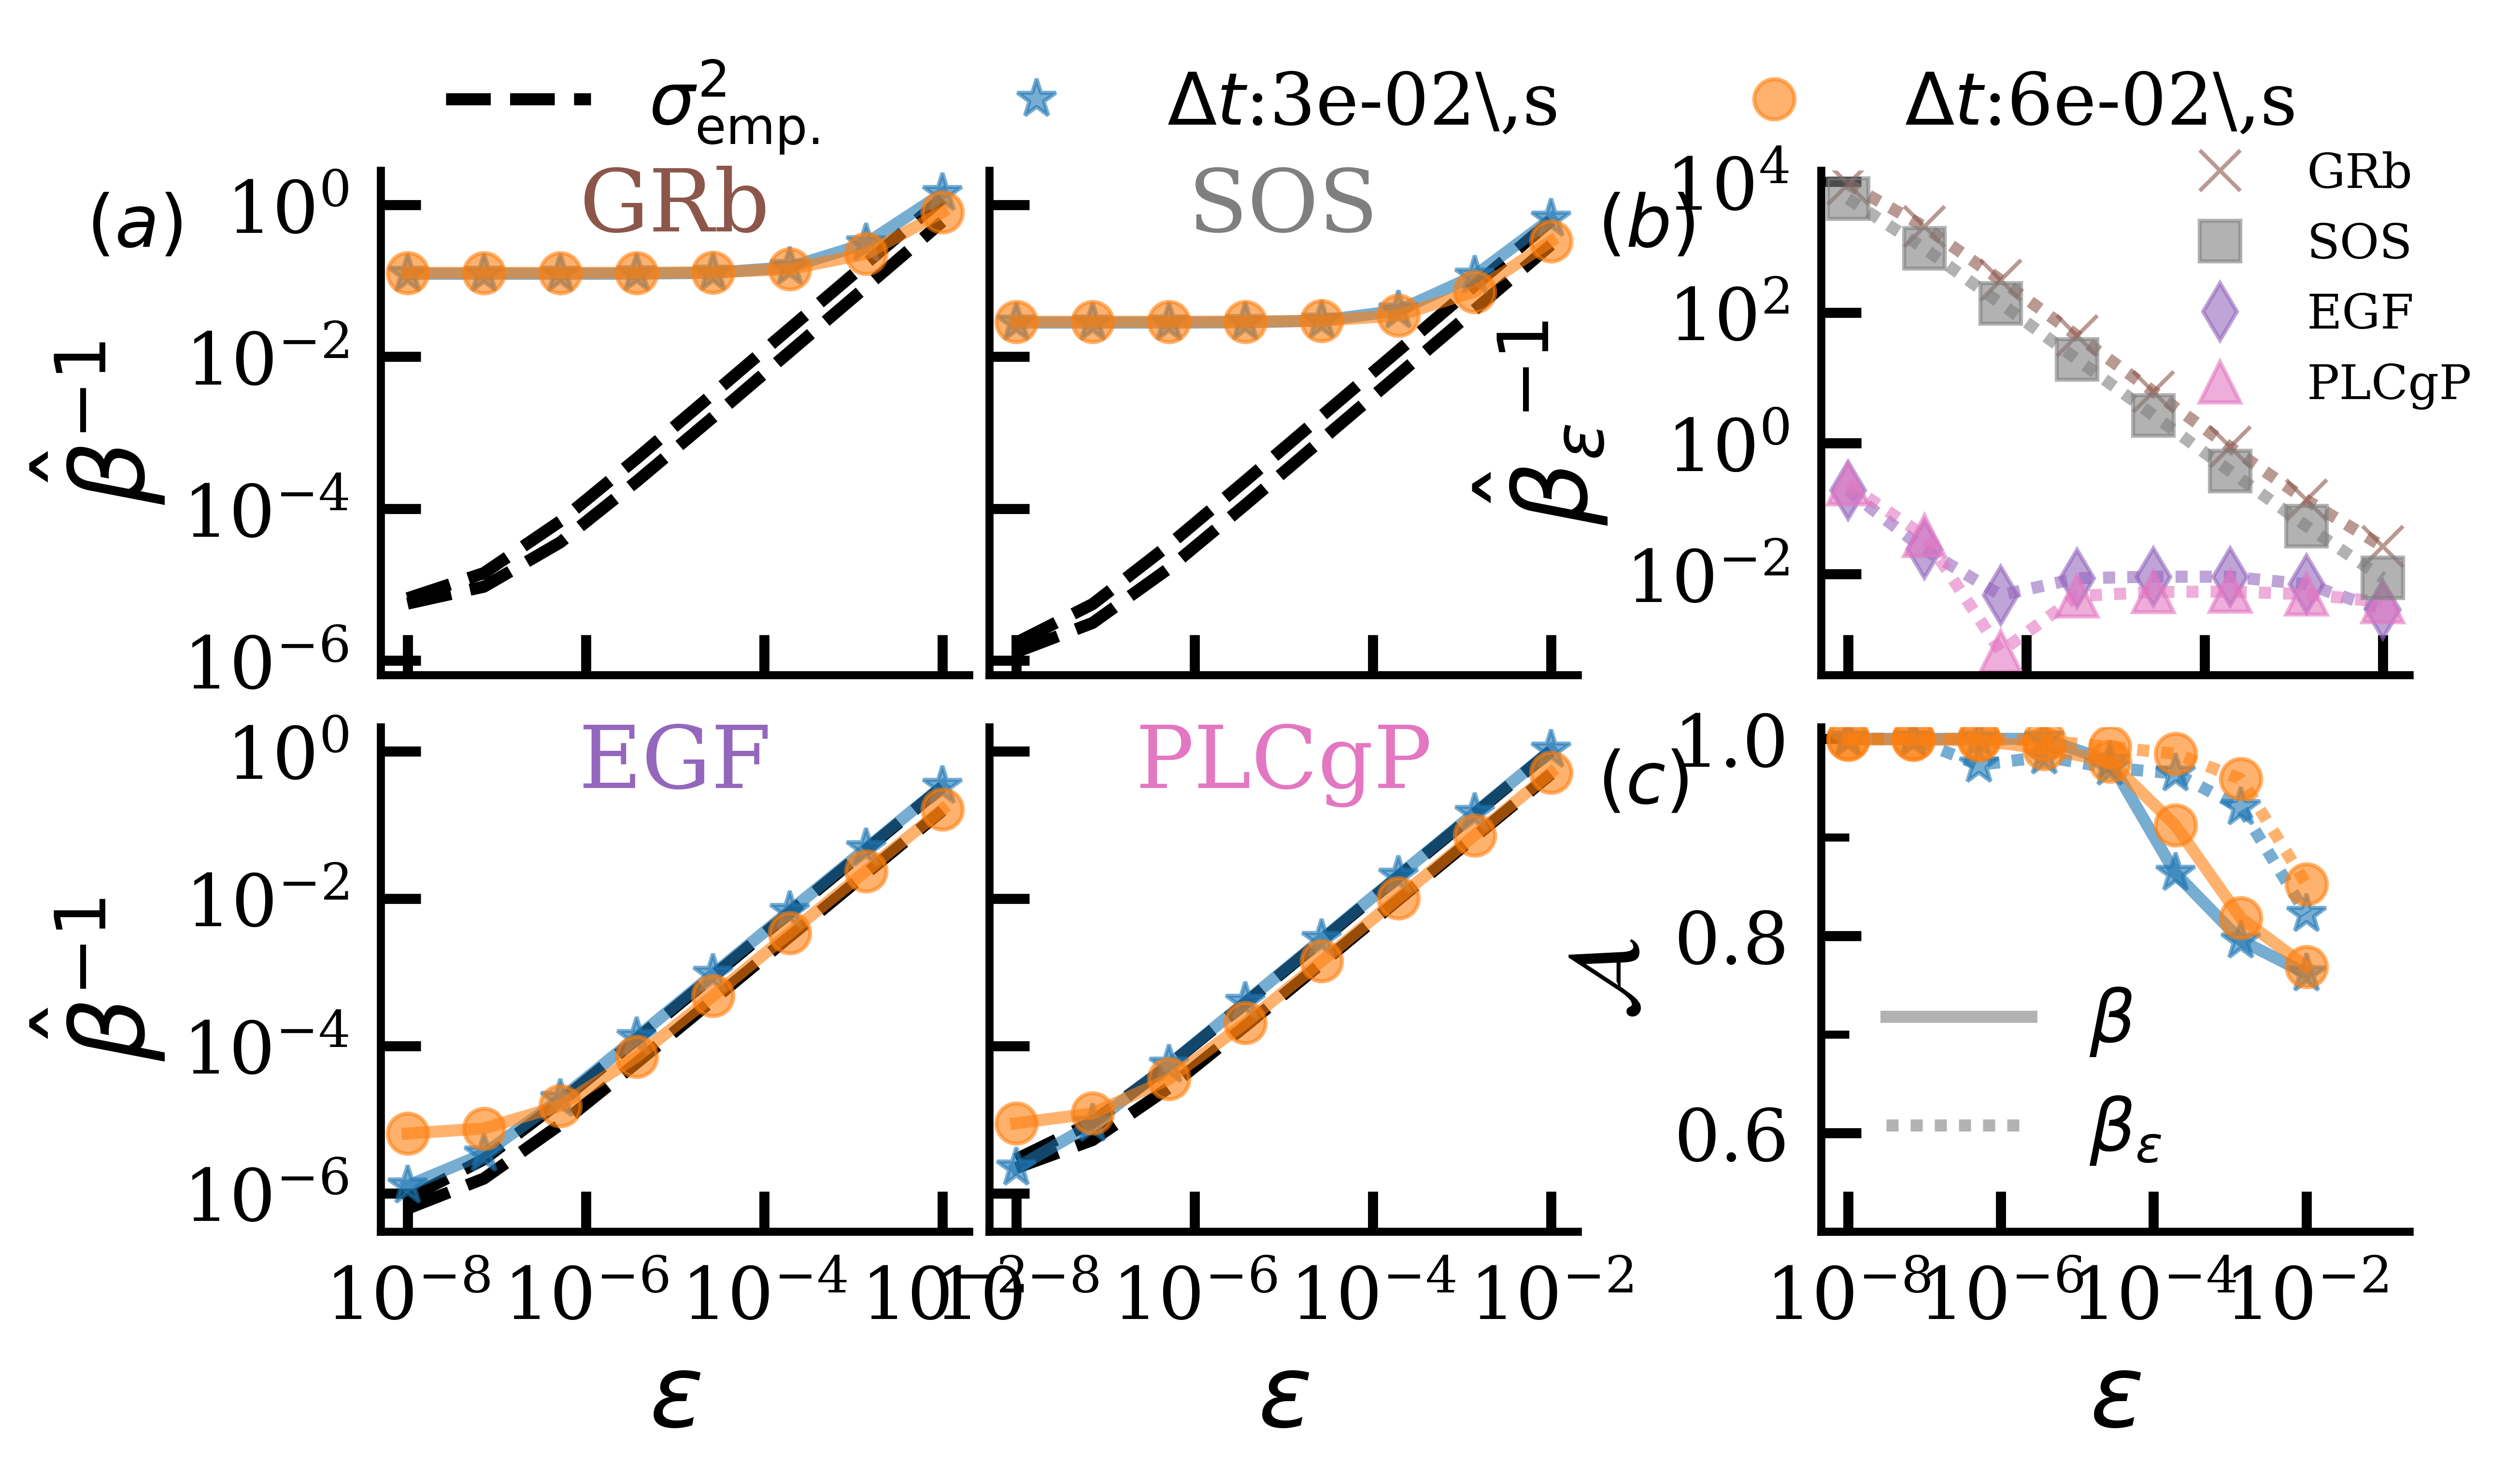

In [21]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(7,6), dpi=600)
#_ax1, _ax2, _ax3, _ax4 = calc_axis(4, .05)

markers= ['*', 'o', 'd']



alpha_m = .6

dx = .29
dy = .29
heig = .32


axEGF = fig.add_axes([0, 0, dx,  dy])
axPL = fig.add_axes([.30, 0, dx, dy], sharey=axEGF)
axGRb = fig.add_axes([0, heig, dx, dy])
axSOS= fig.add_axes([.30, heig, dx, dy], sharey=axGRb)

axBeta= fig.add_axes([.71, heig, dx, dy])
axAUC= fig.add_axes([.71, 0, dx, dy])


axPL.yaxis.set_tick_params(label1On=False)
axSOS.yaxis.set_tick_params(label1On=False)
axGRb.xaxis.set_tick_params(label1On=False)
axSOS.xaxis.set_tick_params(label1On=False)
#axAUC.xaxis.set_tick_params(label1On=True)


#idx_R2 = idx_sub_rel2['R2']
#idx_RP = idx_sub_rel2['RP']

idx_GRb = idx_sub_rel2['GRb']
idx_SOS = idx_sub_rel2['SOS']

idx_PL = idx_sub_rel2['PLCgP']
idx_EGF = idx_sub_rel2['EGF']

pad = -15
y = 1

axEGF.set_title('EGF', color=COLORS(4), y = y, pad=pad)
axGRb.set_title('GRb', color=COLORS(5), y=y , pad=pad)
axPL.set_title('PLCgP', color=COLORS(6),  y=y,  pad=pad )
axSOS.set_title('SOS', color=COLORS(7),   y=y,  pad=pad)



#fig.patch.set_color('white')

for idx, (ax, idx_l) in enumerate(zip([axEGF, axPL, axGRb, axSOS], [idx_EGF, idx_PL, idx_GRb, idx_SOS])): 

    ax.plot(epsilon_list, grad_var_mean[:, idx_dt1, idx_l], '--',  label=s_var_emp, color='k')
    ax.plot(epsilon_list, grad_var_mean[:, idx_dt2, idx_l], '--',   color='k')
    #ax.plot(epsilon_list, grad_var_mean[idx_dt3, :, idx_l], '--',  color=COLORS(7))
    ax.plot(epsilon_list, 1/beta_list_mean[:, idx_dt1, idx_l],alpha=alpha_m, marker=markers[0],label=s_dt + f':{dt_list[idx_dt1]:.0e}'+ '\,s', color=COLORS(0))
    ax.plot(epsilon_list, 1/beta_list_mean[:, idx_dt2, idx_l],alpha=alpha_m, marker=markers[1],label=s_dt + f':{dt_list[idx_dt2]:.0e}' + '\,s', color=COLORS(1))
    #ax.plot(epsilon_list, 1/beta_list_mean[idx_dt3, :, idx_l],alpha=alpha_m, marker=markers[2], label=r'$dt$' + f': {dt_list[idx_dt3]:.1e} ', color=COLORS(2))
    #a1.set_title('R2', fontweight='normal')
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel(r'$\epsilon$')

    ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=1e-8, subs=[1, 1e2, 1e4, 1e6]))
    #ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=1e-8, subs=[1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]))
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.yaxis.set_major_locator(mpl.ticker.LogLocator(base=1e-8, subs=[1, 1e2, 1e4, 1e6]))
    ax.yaxis.set_minor_locator(mpl.ticker.LogLocator(base=1e-8, subs=[1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]))
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    ax.yaxis.set_minor_locator(mpl.ticker.NullLocator())
    ax.xaxis.set_minor_locator(mpl.ticker.NullLocator())




#ax1.set_xlabel(r'$\epsilon$')
axEGF.set_ylabel(s_beta_hat + r'$^{-1}$')
axGRb.set_ylabel(s_beta_hat + r'$^{-1}$')





####################################### AUC PLOTS ##########################
#idx_dt = 0
marker_list = ['*', 'o']



for i, idx_dt in enumerate(idx_dt_list): 
    marker = marker_list[i]
    
    axAUC.plot(epsilon_list, auc_dev[:, idx_dt], marker=marker,alpha=alpha_m, color=COLORS(i), label=s_beta_red, ls=(0,(1,1)))
    axAUC.plot(epsilon_list, auc_sin[:, idx_dt], marker=marker,alpha=alpha_m, color=COLORS(i), label=s_beta, ls ='-')

    axAUC.set_ylabel(s_auc)
    axAUC.set_xscale('log')
    axAUC.set_xlabel(r'$\epsilon$')
    axAUC.legend(frameon=True, framealpha=.3)


axAUC.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(.1))
axAUC.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=1e-8, subs=[1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]))
axAUC.xaxis.set_minor_locator(mpl.ticker.NullLocator())
axAUC.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
axAUC.xaxis.set_major_locator(mpl.ticker.LogLocator(base=1e-8, subs=[1, 1e2, 1e4, 1e6]))

axAUC.set_ylim(ymin=0.5)

dt1, =  axAUC.plot(0.1, -1, color=COLORS(0), label=s_dt + ':' + f'{dt_list[idx_dt_list[0]]:.0e}\,s', alpha=alpha_m, marker='*', lw=0)

dt2, =  axAUC.plot(0, -1, color=COLORS(1), label=s_dt + ':' + f'{dt_list[idx_dt_list[1]]:.0e}\,s', alpha=alpha_m, marker='o', lw=0)
sigma_emp, = axAUC.plot(0, -1, ls='--', color='k', label=s_var_emp)



beta_red, =  axAUC.plot(0, -1, color='grey', label=s_beta_red, alpha=alpha_m, ls=(0,(1,1)))
beta_norm, = axAUC.plot(0, -1, color='grey', label=s_beta, alpha=alpha_m, ls='-')





######################################## Bottom right ######################
idx_dt = 0

ls = (0,(1,1))

axBeta.plot(epsilon_list, 1/beta_dev_mean[:, idx_dt, idx_EGF], marker='d', alpha=alpha_m,  label=f'EGF',color=COLORS(4), ls=ls)
axBeta.plot(epsilon_list, 1/beta_dev_mean[:, idx_dt, idx_GRb], marker='x', alpha=alpha_m,  label=f'GRb', ls=ls,   color=COLORS(5))
axBeta.plot(epsilon_list, 1/beta_dev_mean[:, idx_dt, idx_PL], marker='^', alpha=alpha_m,  label=f'PLCgP',    color=COLORS(6), ls=ls)
axBeta.plot(epsilon_list, 1/beta_dev_mean[:, idx_dt, idx_SOS], marker='s', alpha=alpha_m, label=f'SOS', ls=ls,   color=COLORS(7))# plt.plot(dt_list, grad_var_mean   [:, idx_eps, idx_sub1], '--', color='grey', label=label_grad_var)
axBeta.set_ylabel(s_beta_red_hat + r'$^{-1}$')
axBeta.set_xscale('log')
axBeta.set_yscale('log')
axBeta.legend(bbox_to_anchor=(.7,.5))

axBeta.xaxis.set_major_locator(mpl.ticker.LogLocator(base=1e-8, subs=[1, 1e2, 1e4, 1e6]))
axBeta.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=1e-8, subs=[1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]))
axBeta.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
axBeta.xaxis.set_major_formatter(mpl.ticker.NullFormatter())

axBeta.yaxis.set_major_locator(mpl.ticker.LogLocator(base=1e-6, subs=[1, 1e2, 1e4, 1e6]))
axBeta.yaxis.set_minor_locator(mpl.ticker.LogLocator(base=1e-6, subs=[1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]))
axBeta.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
axBeta.yaxis.set_minor_locator(mpl.ticker.NullLocator())
axBeta.xaxis.set_minor_locator(mpl.ticker.NullLocator())
axBeta.set_xlabel(f'$\epsilon$')


axBeta.set_ylim(ymax=np.max(1/beta_dev_mean[:, idx_dt])*1.6)

lEGF, = axBeta.plot(0, 10**6, marker='d', alpha=alpha_m,  label=f'EGF',color=COLORS(4), lw = 0)
lGRb, = axBeta.plot(0, 10**6, marker='x', alpha=alpha_m,  label=f'GRb',color=COLORS(5), lw=0)
lPL, = axBeta.plot(0, 10**6, marker='^', alpha=alpha_m,  label=f'PLCgP',color=COLORS(6), lw=0)
lSOS,= axBeta.plot(0, 10**6, marker='s', alpha=alpha_m,  label=f'SOS',color=COLORS(7), lw=0)




#

axGRb.set_xlabel('')
axSOS.set_xlabel('')

#### LEGENDS ####
axGRb.legend(handles=[sigma_emp, dt1, dt2], bbox_to_anchor=(0, .9), loc=3, bbox_transform=axGRb.transAxes, ncol=5)
axAUC.legend(handles=[beta_norm, beta_red], bbox_transform=axAUC.transAxes, ncol=1,)
axBeta.legend(handles=[lGRb, lSOS, lEGF, lPL], bbox_to_anchor=(1.18, .44), fontsize=12, loc=4, bbox_transform=axBeta.transAxes, ncols=1, frameon=False, framealpha=.5)


#### Annotation of plots ###
#trans = mpl.transforms.mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans) 
axGRb.text(-.5, .85, r'${(a)}$', transform=axGRb.transAxes, )
axBeta.text(-.38, .85, r'${(b)}$', transform=axBeta.transAxes, )
axAUC.text(-.38, .85, r'${(c)}$', transform=axAUC.transAxes, )



#plt.savefig('../var_predicted.png', transparent=False, bbox_inches='tight')

